In [39]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization

In [2]:
# Constants
data_folder = 'data/'
image_size = (64, 64)

# Initialize lists for storing images and labels
image_data_flat = []  # For Epsilon-Isomap
image_data_3d = []    # For CNN
labels = []

# Load and preprocess images
for label in os.listdir(data_folder):
    subfolder_path = os.path.join(data_folder, label)
    
    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            # Open, resize, and preprocess the image
            image = Image.open(image_path).convert('RGB').resize(image_size)
            image_array_flat = np.array(image).flatten()  # Flatten for Epsilon-Isomap
            image_array_3d = np.array(image) / 255.0      # Normalize for CNN
            
            # Append to respective lists
            image_data_flat.append(image_array_flat)
            image_data_3d.append(image_array_3d)
            labels.append(label)

# Convert lists to numpy arrays for easier processing
X_flat = np.array(image_data_flat)        # For Epsilon-Isomap
X_3d = np.array(image_data_3d)             # For CNN
y = np.array(labels)

# Encode labels to integers
label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
y_encoded = np.vectorize(label_map.get)(y)

# Split into training and testing sets
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y_encoded, test_size=0.2, random_state=6740)
X_train_3d, X_test_3d, _, _ = train_test_split(X_3d, y_encoded, test_size=0.2, random_state=6740)

In [3]:
# Helper function for confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [29]:
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_flat)

In [36]:
# Perform KMeans clustering with cross-validation
def perform_kmeans_with_cv(X_flat, y, n_clusters=4, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=6740)
    accuracies = []

    for fold, (train_index, test_index) in enumerate(skf.split(X_flat, y)):
        # Split into train and validation sets
        X_train, X_test = X_flat[train_index], X_flat[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply KMeans clustering on the training data
        kmeans = KMeans(n_clusters=n_clusters, random_state=6740)
        train_clusters = kmeans.fit_predict(X_train)

        # Determine the majority class for each cluster
        cluster_labels = {}
        for cluster_id in range(n_clusters):
            cluster_points = y_train[train_clusters == cluster_id]
            majority_class = np.bincount(cluster_points).argmax()  # Find majority label in each cluster
            cluster_labels[cluster_id] = majority_class

        # Predict labels for validation data based on the closest cluster
        test_clusters = kmeans.predict(X_test)
        y_pred = np.array([cluster_labels[cluster] for cluster in test_clusters])

        # Calculate accuracy for the fold and store it
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}")

        # Plot confusion matrix for the last fold
        if fold == n_splits - 1:
            plot_confusion_matrix(y_test, y_pred, f"KMeans Confusion Matrix - Fold {fold + 1}")

    # Print average accuracy over all folds
    mean_accuracy = np.mean(accuracies)
    print(f"\nCross-Validated Accuracy: {mean_accuracy:.4f}")

Fold 1 - Accuracy: 0.5437
Fold 2 - Accuracy: 0.5267
Fold 3 - Accuracy: 0.5458
Fold 4 - Accuracy: 0.5382
Fold 5 - Accuracy: 0.5038


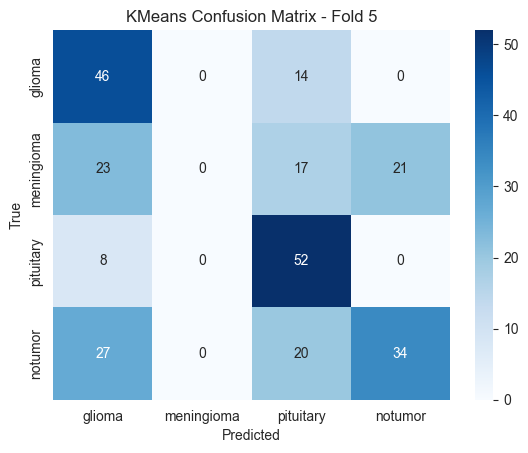


Cross-Validated Accuracy: 0.5316


In [37]:
# Run KMeans with cross-validation
perform_kmeans_with_cv(X_flat=X_scaled, y=y_encoded, n_clusters=4, n_splits=5)

In [ ]:
# Define CNN model structure
def create_cnn(input_shape=(64, 64, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the CNN
def train_cnn(X_train_3d, y_train, X_test_3d, y_test):
    cnn_model = create_cnn(input_shape=(64, 64, 3))
    cnn_model.fit(X_train_3d, y_train, epochs=10, batch_size=32, validation_data=(X_test_3d, y_test))

    # Predict and evaluate
    y_pred = np.argmax(cnn_model.predict(X_test_3d), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    print(f'CNN Accuracy: {accuracy}, F2-score: {f2}')
    plot_confusion_matrix(y_test, y_pred, "CNN Confusion Matrix")

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3902 - loss: 1.2422 - val_accuracy: 0.6198 - val_loss: 0.9116
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7166 - loss: 0.7580 - val_accuracy: 0.7452 - val_loss: 0.6215
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7891 - loss: 0.5548 - val_accuracy: 0.7681 - val_loss: 0.5751
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8476 - loss: 0.4311 - val_accuracy: 0.7985 - val_loss: 0.5155
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8762 - loss: 0.3459 - val_accuracy: 0.8099 - val_loss: 0.5074
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8852 - loss: 0.2910 - val_accuracy: 0.8137 - val_loss: 0.5068
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9186 - loss: 0.1969 - val_accuracy: 0.8213 - val_loss: 0.5914
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9548 - loss: 0.1332 - val_accuracy: 0.8175 - v

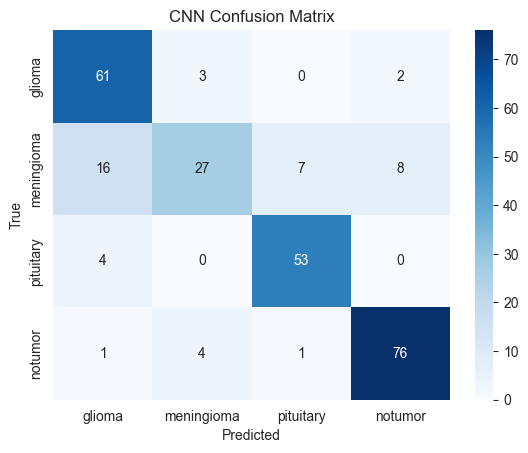

In [43]:

# Run CNN function
train_cnn(X_train_3d, y_train, X_test_3d, y_test)